# References
https://machinelearningmastery.com/how-to-train-an-object-detection-model-with-keras/

https://www.kaggle.com/code/serhanayberkkl/car-detection-rcnn-acc-97/notebook

https://www.kaggle.com/code/ashishsingh226/car-detection-using-maskrcnn

# 1. Importing and Installing libraries

In [1]:
# Import M-RCNN packages
!git clone https://github.com/leekunhee/Mask_RCNN.git
!cd Mask_RCNN && python setup.py install

# Import OpenCV packages
!pip uninstall --yes opencv-contrib-python opencv-python
!pip install opencv-contrib-python

Cloning into 'Mask_RCNN'...
remote: Enumerating objects: 983, done.
remote: Total 983 (delta 0), reused 0 (delta 0), pack-reused 983
Receiving objects: 100% (983/983), 149.27 MiB | 13.90 MiB/s, done.
Resolving deltas: 100% (572/572), done.
running install
running bdist_egg
running egg_info
creating mask_rcnn.egg-info
writing mask_rcnn.egg-info/PKG-INFO
writing dependency_links to mask_rcnn.egg-info/dependency_links.txt
writing top-level names to mask_rcnn.egg-info/top_level.txt
writing manifest file 'mask_rcnn.egg-info/SOURCES.txt'
reading manifest template 'MANIFEST.in'
writing manifest file 'mask_rcnn.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
creating build
creating build/lib
creating build/lib/mrcnn
copying mrcnn/model.py -> build/lib/mrcnn
copying mrcnn/visualize.py -> build/lib/mrcnn
copying mrcnn/config.py -> build/lib/mrcnn
copying mrcnn/utils.py -> build/lib/mrcnn
copying mrcnn/__init__.py -> build/lib/mrc

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import os,sys
import random
import cv2
import pandas as pd
import numpy as np
from os import listdir
from numpy import zeros, asarray, expand_dims, mean
from matplotlib import pyplot

ROOT_DIR = os.path.abspath("./Mask_RCNN")
sys.path.append(ROOT_DIR) 

from mrcnn.utils import Dataset,extract_bboxes
from mrcnn.visualize import display_instances
from mrcnn.config import Config
from mrcnn.model import MaskRCNN
from mrcnn.utils import compute_ap
from mrcnn.model import load_image_gt
from mrcnn.model import mold_image

import warnings
warnings.filterwarnings("ignore")

# 2. Load dataset

In [3]:
# Read data annotation rectangle box coordinates for each image sample from .xls file
bb_df = pd.read_csv('../input/car-object-detection/data/train_solution_bounding_boxes (1).csv')

In [4]:
# Displaying the first couple of rows
bb_df.head()

image        xmin        ymin        xmax        ymax
0   vid_4_1000.jpg  281.259045  187.035071  327.727931  223.225547
1  vid_4_10000.jpg   15.163531  187.035071  120.329957  236.430180
2  vid_4_10040.jpg  239.192475  176.764800  361.968162  236.430180
3  vid_4_10020.jpg  496.483358  172.363256  630.020261  231.539575
4  vid_4_10060.jpg   16.630970  186.546010  132.558611  238.386422

In [5]:
# Checking the distribution of data
bb_df.describe()

xmin        ymin        xmax        ymax
count  559.000000  559.000000  559.000000  559.000000
mean   263.387486  186.517539  365.324845  231.500472
std    207.368388    9.315974  213.501175   13.987176
min      0.000000  148.399292   28.556446  198.321729
25%     61.387844  180.109294  166.309696  223.225547
50%    236.746744  187.524131  348.585579  230.561454
75%    446.835022  193.881918  571.322721  237.897362
max    645.183792  208.064672  676.000000  308.322072

In [6]:
# Count of unique values in the dataset
bb_df.nunique() 

image    355
xmin     440
ymin     149
xmax     438
ymax     184
dtype: int64

In [7]:
print(len(bb_df))

559


In [8]:
print('Image(Train):',len(os.listdir('../input/car-object-detection/data/training_images')))
print('Image(Test):',len(os.listdir('../input/car-object-detection/data/testing_images')))

Image(Train): 1001
Image(Test): 175


In [9]:
# Dataset class to load the images and their bounding boxes in the form of masks
# Train set: 1001 (559 are annotated)
# Test set: 175
class CarsDataset(Dataset):

    # Load the dataset and split the data
    # Train data: 1-500 images (annotated)
    # Validation set: 500-559 images (annotated)
    # Test set: 175 (not annotated) 
    def load_dataset(self, dataset_dir='../input/car-object-detection/data', mode='train'):
        
        self.add_class('dataset',1,'car')
        if mode=='train':
            images_dir = dataset_dir + '/training_images/'
            for i in range(500):
                image_id = bb_df.iloc[i,0]
                img_path = images_dir + image_id
                self.add_image('dataset', image_id=image_id, path=img_path)
        if mode=='val':
            images_dir = dataset_dir + '/training_images/'
            for i in range(500,len(bb_df)):
                image_id = bb_df.iloc[i,0]
                img_path = images_dir + image_id
                self.add_image('dataset', image_id=image_id, path=img_path)
        if mode=='test':
            images_dir = dataset_dir + '/testing_images/'
            for filename in listdir(images_dir):
                image_id = filename
                img_path = images_dir + filename
                self.add_image('dataset', image_id=image_id, path=img_path)
    
    # Extract annotation box for each images
    def extract_boxes(self, filename):
        
        # To get the coordinates of the bounding boxes.
        boxes = list()
        xmin = int(bb_df[bb_df['image']==filename].iloc[0,1])
        ymin = int(bb_df[bb_df['image']==filename].iloc[0,2])
        xmax = int(bb_df[bb_df['image']==filename].iloc[0,3])
        ymax = int(bb_df[bb_df['image']==filename].iloc[0,4])
        coors = [xmin, ymin, xmax, ymax]
        boxes.append(coors)
        width = 380
        height = 676
        return boxes, width, height
    
    # Takes the annotated co-ordinates and uses that to make it into a mask.
    def load_mask(self, image_id):
        info = self.image_info[image_id]
        file = info['id']
        boxes, w, h = self.extract_boxes(file)
        masks = zeros([w, h, len(boxes)], dtype='uint8')
        class_ids = list()
        for i in range(len(boxes)):
            box = boxes[i]
            row_s, row_e = box[1], box[3]
            col_s, col_e = box[0], box[2]
            masks[row_s:row_e, col_s:col_e, i] = 1
            class_ids.append(self.class_names.index('car'))
        return masks, asarray(class_ids, dtype='int32')
    
    # Return the images file nmae from image id 
    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path']

# 3. Visualize Mask-RCNN masking

In [10]:
#Loading all the annotated datasets

train_set = CarsDataset()
train_set.load_dataset(mode='train')
train_set.prepare()
print(train_set.image_ids)
print()
print('Train set: %d' % len(train_set.image_ids))

val_set = CarsDataset()
val_set.load_dataset(mode='val')
val_set.prepare()
# print(val_set.image_ids)
# print()
print('Validation set: %d' % len(val_set.image_ids))
 
test_set = CarsDataset()
test_set.load_dataset(mode='test')
test_set.prepare()
# print(test_set.image_ids)
# print()
print('Test set: %d' % len(test_set.image_ids))

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243 244 245 24

## 3.1 Using pyplot visualization

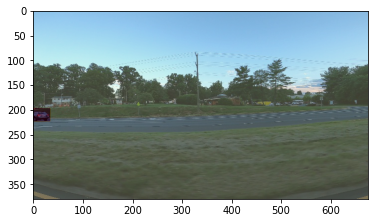

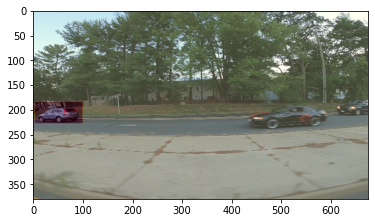

In [11]:
def plot(num_img=2):
    for i in range(num_img):
        image_id = np.random.randint(0,len(train_set.image_ids))
        image = train_set.load_image(image_id)
        mask, class_ids = train_set.load_mask(image_id)
        pyplot.imshow(image)
        pyplot.imshow(mask[:, :, 0], cmap='YlOrRd', alpha=0.25)
        pyplot.show()

plot()

## 3.2 Using OpenCV visualization

(380, 676, 3)
(380, 676, 3)


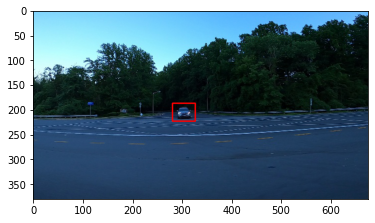

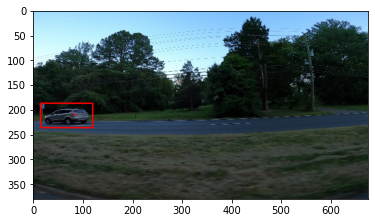

In [12]:
for a,i in enumerate(bb_df.values):
  img=plt.imread('../input/car-object-detection/data/training_images/'+i[0])
  print(img.shape)
  #plt.figure()
  #plt.imshow(img)
  xmin=int(i[1])
  ymin=int(i[2])
  xmax=int(i[3])
  ymax=int(i[4])
  cv2.rectangle(img,(xmin, ymin),(xmax, ymax),(255, 0, 0),2)
  plt.figure()
  plt.imshow(img)
  if a == 1:
    break

# 4. Preprocessing

## 4.1 Using Segmentation and Selective Search for Feature Extraction using OpenCV

In [13]:
# Define OpenCV Selective Search algorithm
cv2.setUseOptimized(True)
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

### 4.1.1 Test the Selective Search Algorithm 

Shape:  (224, 224, 3)
Possible Bounty Boxes: 213


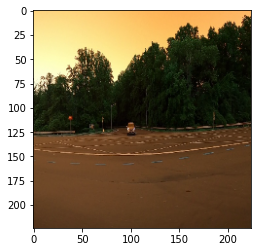

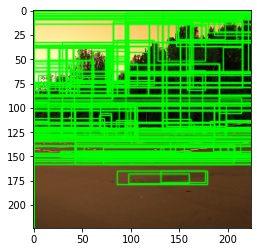

In [14]:
# Check Selective Search Algorithm for a specific image
# Search for window that match the annotated area

# Test wind for an image
im = cv2.imread('../input/car-object-detection/data/training_images/vid_4_1000.jpg')
im=cv2.resize(im,(224,224))
plt.figure()
plt.imshow(im)

ss.setBaseImage(im)
ss.switchToSelectiveSearchFast() # Selective Search süresini hızlandırmak için

rects = ss.process()
print('Shape: ',im.shape)
print('Possible Bounty Boxes:',len(rects))

for rect in rects:
  x, y, w, h = rect
  imOut=cv2.rectangle(im, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)
plt.figure()
plt.imshow(imOut);

### 4.1.2 IOU calculation for correctly labeling the Box of Selective Algorithm 

In [15]:
# Define IOU calculation
# bb1 --> Old box area
# bb2 --> new box area
# IOU>=0.5 label 1 --> car image
# else 0 --> not car
def get_iou(bb1, bb2):

    assert bb1['x1'] < bb1['x2'] #bb1
    assert bb1['y1'] < bb1['y2']

    assert bb2['x1'] < bb2['x2'] #bb2
    assert bb2['y1'] < bb2['y2'];

    x_left = max(bb1['x1'], bb2['x1'])
    y_top = max(bb1['y1'], bb2['y1'])
    x_right = min(bb1['x2'], bb2['x2'])
    y_bottom = min(bb1['y2'], bb2['y2'])

    if x_right < x_left or y_bottom < y_top:
      return 0.0
    intersection_area = (x_right - x_left) * (y_bottom - y_top)
    bb1_area = (bb1['x2'] - bb1['x1']) * (bb1['y2'] - bb1['y1'])
    bb2_area = (bb2['x2'] - bb2['x1']) * (bb2['y2'] - bb2['y1'])
    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    assert iou >= 0.0
    assert iou <= 1.0
    return iou

In [16]:
print(ss.process())

[[ 58  95  47  34]
 [  0  37  98  51]
 [  0   0 224  75]
 [198 113  26   7]
 [  0 139 224  85]
 [  0  63  23  19]
 [139  10  70  23]
 [  0  14 224 135]
 [ 34  37  42  35]
 [  0 121 224  32]
 [ 98 168  62  10]
 [  0  95 224 129]
 [ 82  55  25  22]
 [  0  59  38  28]
 [ 97  11  65  45]
 [ 76  53  19  26]
 [  0  33 151  91]
 [161  16  17  15]
 [198 115  26   6]
 [  0 135 224  89]
 [ 52 140 155  15]
 [186   6  38  20]
 [133   5  91 119]
 [147  11  50  19]
 [  0 140 224  84]
 [ 52 149  73   2]
 [  0   0 224  88]
 [165 119  32   8]
 [105  96  81  35]
 [  0 116  73  14]
 [  0   0 224  74]
 [134 139  66   8]
 [  0 122 224  27]
 [ 79  52  17  21]
 [  0  95 224  54]
 [  0   9 224 115]
 [133   5  91  74]
 [146 137  78  14]
 [ 43 139 157  10]
 [ 86  31  38  41]
 [ 95   3 129  64]
 [131 165  46  12]
 [104 116  61   9]
 [  0 120  43   8]
 [  0 121 224  28]
 [180   0  44  23]
 [ 47  38  30  31]
 [ 28 145 118   4]
 [ 95  43  23  24]
 [  0  37  86  51]
 [149   3  75  28]
 [ 34  37  62  41]
 [ 39 100  2

### 4.1.3 Test the Selective Search Algorithm for all images 

In [17]:
# Run Selective Search Algorithm for all Train image
image_list=[]
k=0
l=0
z=0

for a in pd.read_csv('../input/car-object-detection/data/train_solution_bounding_boxes (1).csv').values:
  Name,xmin,ymin,xmax,ymax = a
  bb1={
            'x1':int(xmin),
            'y1':int(ymin),
            'x2':int(xmax),
            'y2':int(ymax)
            }
  try:
    img=cv2.imread('../input/car-object-detection/data/training_images/'+Name)
    ss.setBaseImage(img)
    ss.switchToSelectiveSearchFast()
    rects = ss.process()
    for i in rects:
      # Selective bounty Box
      x, y, w, h = i 
      bb2={'x1':x, 
          'y1':y,
          'x2':x+w,
          'y2':y+h
          }
        
      # Crop image
      # Store features and labels for the cropped image box
      img1=img[bb2['y1']:bb2['y2'],bb2['x1']:bb2['x2']]
      img1_shape=cv2.resize(img1,(224,224))
      if k<l:
            if 0.5<get_iou(bb1,bb2):  
              image_list.append([img1_shape,1])
              k+=1
      else:
        if 0.5<get_iou(bb1,bb2):  
          image_list.append([img1_shape,1])
          k+=1
        else:
          image_list.append([img1_shape,0])
          l+=1
  except Exception as e:
    print('File not found!',e)
  z+=1
  print(Name,z,len(rects))

vid_4_1000.jpg 1 1101
vid_4_10000.jpg 2 1456
vid_4_10040.jpg 3 1403
vid_4_10020.jpg 4 1489
vid_4_10060.jpg 5 1315
vid_4_10100.jpg 6 1537
vid_4_10120.jpg 7 1430
vid_4_10140.jpg 8 1544
vid_4_1020.jpg 9 1117
vid_4_1040.jpg 10 1146
vid_4_10480.jpg 11 1663
vid_4_10500.jpg 12 1815
vid_4_10520.jpg 13 1725
vid_4_1060.jpg 14 1251
vid_4_10960.jpg 15 1894
vid_4_10980.jpg 16 1676
vid_4_11000.jpg 17 1754
vid_4_11020.jpg 18 1553
vid_4_11240.jpg 19 1779
vid_4_11260.jpg 20 1863
vid_4_11280.jpg 21 1846
vid_4_11380.jpg 22 1884
vid_4_11400.jpg 23 1929
vid_4_11420.jpg 24 1925
vid_4_11440.jpg 25 1880
vid_4_11900.jpg 26 1801
vid_4_11880.jpg 27 1824
vid_4_11920.jpg 28 1857
vid_4_11940.jpg 29 1947
vid_4_11960.jpg 30 1932
vid_4_11980.jpg 31 1970
vid_4_12000.jpg 32 1901
vid_4_12040.jpg 33 1979
vid_4_12100.jpg 34 1971
vid_4_12060.jpg 35 1879
vid_4_12080.jpg 36 1870
vid_4_12120.jpg 37 1821
vid_4_12140.jpg 38 1632
vid_4_12140.jpg 39 1632
vid_4_12160.jpg 40 1682
vid_4_12160.jpg 41 1682
vid_4_12160.jpg 42 1682
vid_4

In [18]:
print("Number of Selective Search Feature: ",len(image_list))

Number of Selective Search Feature:  10581


### 4.1.4 Assign label to selective box feature (1 = Car, 0 = No Car)  

Assigned label Done!
Number of Feature: 10581 | Number of Label: 10581
No car image: 5291 |There is car image: 5290
Label:  1
Box Size: (224, 224, 3)


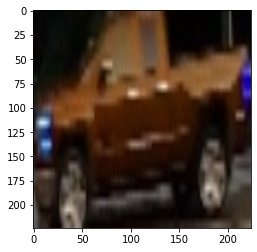

In [19]:
data=[]
data_label=[]
for features,label in image_list:
  data.append(features)
  data_label.append(label)
print('Assigned label Done!')
print('Number of Feature:',len(data),'| Number of Label:',len(data_label))



data=np.asarray(data)
data_label=np.asarray(data_label) 
print('No car image:',len(data_label[data_label==0]),'|There is car image:',len(data_label[data_label==1]))

# Print a random image feature with label
i=random.randint(1,len(data_label))

# Label 1 --> car, Label -0 --> No car/ part of a car
print('Label: ',data_label[i])
print('Box Size:',data[i].shape)
plt.imshow(data[i]);

### 4.1.5 Split Selective Box Feature into Train and Validation set  

In [20]:
from sklearn.model_selection import train_test_split

x_train,x_val,y_train,y_val=train_test_split(data,data_label,test_size=0.33, random_state=42)

print('x_train shape:',x_train.shape)
print('x_val shape:',x_val.shape)
print('y_train shape:',y_train.shape)
print('y_val shape:',y_val.shape)

x_train shape: (7089, 224, 224, 3)
x_val shape: (3492, 224, 224, 3)
y_train shape: (7089,)
y_val shape: (3492,)


### 4.1.6 Define Pretrained VGG16 Model and Imagenet Weights

In [21]:
# Define VGG16 Pretrained Model
base_model=tf.keras.applications.VGG16(include_top=False,input_shape=(224,224,3),weights='imagenet')
base_model.summary()

58892288/58889256 [==============================] - 0s 0us/step: 
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
____________________________________________________________

In [22]:
# Add extra layer at bottom of pretrained 
model1=tf.keras.Sequential()
model1.add(base_model)
model1.add(tf.keras.layers.GlobalMaxPooling2D())
model1.add(tf.keras.layers.Dropout(0.5))
model1.add(tf.keras.layers.Dense(1,activation='sigmoid'))
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
global_max_pooling2d (Global (None, 512)               0         
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 513       
Total params: 14,715,201
Trainable params: 14,715,201
Non-trainable params: 0
_________________________________________________________________


In [23]:
#Freeze all the layer of VGG16 to store the pretrained weights
base_model.trainable=False
for i,layer in enumerate(base_model.layers):
  print(i,layer.name,'-',layer.trainable)

0 input_1 - False
1 block1_conv1 - False
2 block1_conv2 - False
3 block1_pool - False
4 block2_conv1 - False
5 block2_conv2 - False
6 block2_pool - False
7 block3_conv1 - False
8 block3_conv2 - False
9 block3_conv3 - False
10 block3_pool - False
11 block4_conv1 - False
12 block4_conv2 - False
13 block4_conv3 - False
14 block4_pool - False
15 block5_conv1 - False
16 block5_conv2 - False
17 block5_conv3 - False
18 block5_pool - False


## 4.2 Define Preprocessing Setting for MaskRCNN and Pretrained Resnet101 COCO weights

### 4.2.1 Configuration setting for Mask-RCNN and ResNet101 Pretrained Configuration

In [24]:
class CarsConfig(Config):
    NAME = "cars_cfg"
    
    #Background is counted as class too so background + cars = 2 labels
    NUM_CLASSES = 2
    STEPS_PER_EPOCH = 200
    VALIDATION_STEPS = 20
    IMAGES_PER_GPU = 1
    IMAGE_MIN_DIM = 384
    IMAGE_MAX_DIM = 448
    LEARNING_RATE = 0.00003
    
config = CarsConfig()

In [25]:
#list of all available configurations
config.display() 


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  448
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  384
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [448 448   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  3e-05
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE             

### 4.2.2 Import Config setting for Mask-RCNN

In [26]:
model2 = MaskRCNN(mode='training', model_dir='./', config=config)

### 4.2.3 Load Prerained weight from COCO for Mask-RCNN

In [27]:
model2.load_weights('../input/mask-rcnn-coco-weights/mask_rcnn_coco.h5', by_name=True, exclude=["mrcnn_class_logits", "mrcnn_bbox_fc",  "mrcnn_bbox", "mrcnn_mask"])

# 5. Train the Model

### 5.1 From OpenCV Selective Feature based Training using Pretrained VGG16 + ImageNet weights   

In [28]:
model1.compile(loss='binary_crossentropy',optimizer=tf.keras.optimizers.Adam(),metrics=['accuracy'])

In [29]:
epoch=4
hist=model1.fit(x_train,y_train,epochs=epoch,validation_data=(x_val,y_val))

Train on 7089 samples, validate on 3492 samples
Epoch 1/4
7089/7089 [==============================] - 1172s 165ms/sample - loss: 4.7499 - accuracy: 0.7943 - val_loss: 1.1176 - val_accuracy: 0.9316
Epoch 2/4
7089/7089 [==============================] - 1140s 161ms/sample - loss: 2.2844 - accuracy: 0.8895 - val_loss: 0.9596 - val_accuracy: 0.9479
Epoch 3/4
7089/7089 [==============================] - 1140s 161ms/sample - loss: 1.6226 - accuracy: 0.9117 - val_loss: 0.5829 - val_accuracy: 0.9588
Epoch 4/4
7089/7089 [==============================] - 1140s 161ms/sample - loss: 1.2386 - accuracy: 0.9182 - val_loss: 0.4730 - val_accuracy: 0.9605


### 5.2 From Mask-RCNN based Training using Pretrained ResNet101 + COCO weights 

In [30]:
model2.train(train_set, val_set, learning_rate=config.LEARNING_RATE, epochs=10, layers='all')


Starting at epoch 0. LR=3e-05

Checkpoint Path: ./cars_cfg20230331T1501/mask_rcnn_cars_cfg_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)
bn3a_branch2b          (BatchNo

# 6. Evaluation

### 6.1 Evaluate Selective Search Pretrained VGG + ImageNet weight approach

Number of possible objects in the photo:  2037
How many possible bounty boxes with class predictions of 1: 79
-------------------------------------------------------------------------


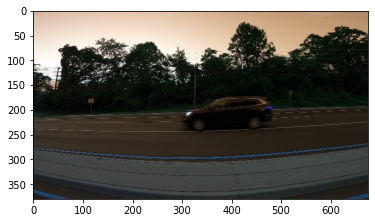

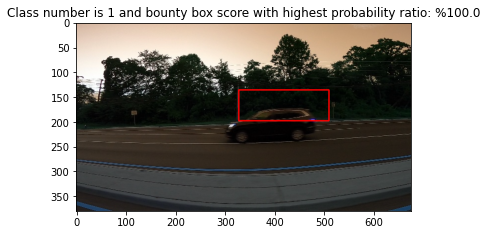

In [39]:
car=[]
photo_path='../input/car-object-detection/data/testing_images/vid_5_27620.jpg'
test_img=cv2.imread(photo_path)
ss.setBaseImage(test_img)
ss.switchToSelectiveSearchFast()
rects1 = ss.process()
print('Number of possible objects in the photo: ',len(rects1))
for i in rects1:
  x, y, w, h = i
  bb3={'x1':x,
        'y1':y,
        'x2':x+w,
        'y2':y+h
      }
  try:
    assert bb3['x1'] < bb3['x2']
    assert bb3['y1'] < bb3['y2']
    img_data=test_img[bb3['y1']:bb3['y2'],bb3['x1']:bb3['x2']]
    img_data=cv2.resize(img_data,(224,224))
    tahmin=model1.predict(img_data.reshape(1,224,224,3))
    if tahmin[0]>0.5:
      car.append([bb3,tahmin[0]])
    else:
      pass
  except Exception as e:
    print('hata',e)
print('How many possible bounty boxes with class predictions of 1:',len(car))
print('-------------------------------------------------------------------------')
test_img=cv2.imread(photo_path)
car[np.argmax(np.array(car)[:,1])][0]
pt1=(car[np.argmax(np.array(car)[:,1])][0]['x1'],car[np.argmax(np.array(car)[:,1])][0]['y1'])
pt2=(car[np.argmax(np.array(car)[:,1])][0]['x2'],car[np.argmax(np.array(car)[:,1])][0]['y2'])
plt.figure()
plt.imshow(test_img)
cv2.rectangle(test_img,pt1,pt2,(255, 0, 0),2)
plt.figure()
plt.title(f'Class number is 1 and bounty box score with highest probability ratio: %{car[np.argmax(np.array(car)[:,1])][1][0]*100}') 
plt.imshow(test_img);

### 6.2 Evaluate Mask-RCNN Pretrained Reset101 + COCO weight approach

In [40]:
class PredictionConfig(Config):
    NAME = "cars_cfg"
    NUM_CLASSES = 2
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    USE_MINI_MASK = False

In [41]:
cfg = PredictionConfig()
model = MaskRCNN(mode='inference', model_dir='./', config=cfg)

### Loading the saved weights to perform inference.

In [43]:
for i in listdir():
    if i[:4]=='cars':
        path=i
model.load_weights('./'+path+'/mask_rcnn_cars_cfg_0010.h5', by_name=True)

Re-starting from epoch 10


### Mean Average Precision evaluation
#Reference: https://towardsdatascience.com/map-mean-average-precision-might-confuse-you-5956f1bfa9e2

In [44]:
def evaluate_model(dataset, model, cfg):
    APs = list()
    for image_id in dataset.image_ids:
        image, image_meta, gt_class_id, gt_bbox, gt_mask = load_image_gt(dataset, cfg, image_id)
        scaled_image = mold_image(image, cfg)
        sample = expand_dims(scaled_image, 0)
        yhat = model.detect(sample, verbose=0)
        r = yhat[0]
        AP, _, _, _ = compute_ap(gt_bbox, gt_class_id, gt_mask, r["rois"], r["class_ids"], r["scores"], r['masks'])
        APs.append(AP)
    mAP = mean(APs)
    return mAP

In [45]:
train_mAP = evaluate_model(train_set, model, cfg)
print("Train mAP: %.3f" % train_mAP)
val_mAP = evaluate_model(val_set, model, cfg)
print("Validation mAP: %.3f" % val_mAP)

Train mAP: 0.797
Validation mAP: 0.782


### Actual vs Predicted

Finally we will compare our model preformances by simply seeing how well it is detecting cars compared to the real bounding boxes.

In [47]:
def plot_actual_vs_predicted(dataset, model, cfg, n_images=5):
    for i in range(n_images):
        id = np.random.randint(0,len(dataset.image_ids))
        pyplot.figure(figsize=(50, 50))
        image = dataset.load_image(id)
        mask, _ = dataset.load_mask(id)
        scaled_image = mold_image(image, cfg)
        sample = expand_dims(scaled_image, 0)
        yhat = model.detect(sample, verbose=0)[0]
        pyplot.subplot(n_images, 2, i*2+1)
        pyplot.imshow(image)
        pyplot.title('Actual')
        for j in range(mask.shape[2]):
            pyplot.imshow(mask[:, :, j], cmap='gray', alpha=0.3)
        pyplot.subplot(n_images, 2, i*2+2)
        pyplot.imshow(image)
        pyplot.title('Predicted')
        ax = pyplot.gca()
        for box in yhat['rois']:
            y1, x1, y2, x2 = box
            width, height = x2 - x1, y2 - y1
            rect = Rectangle((x1, y1), width, height, fill=False, color='red')
            ax.add_patch(rect)
    pyplot.show()

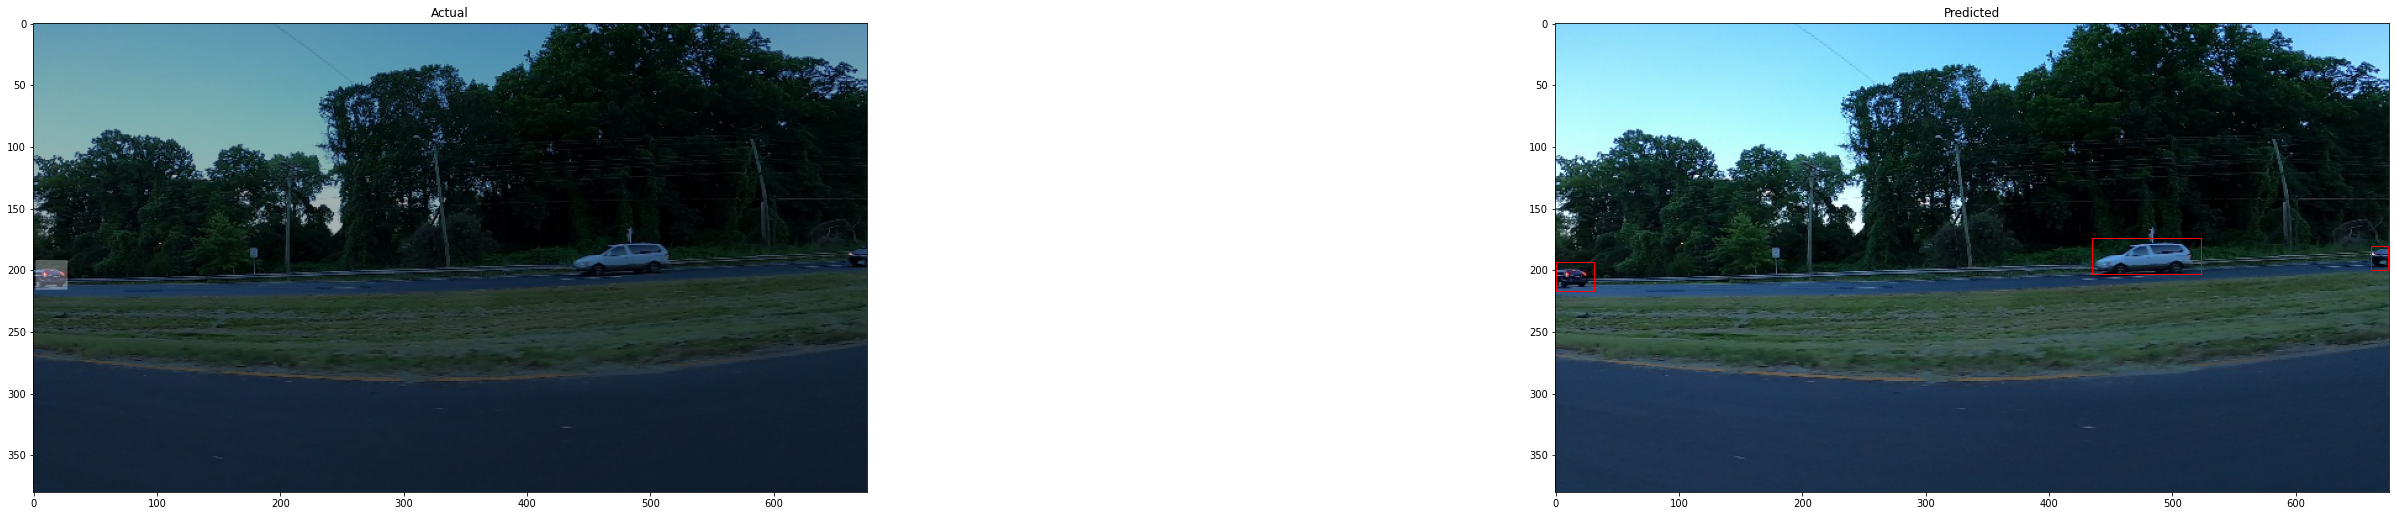

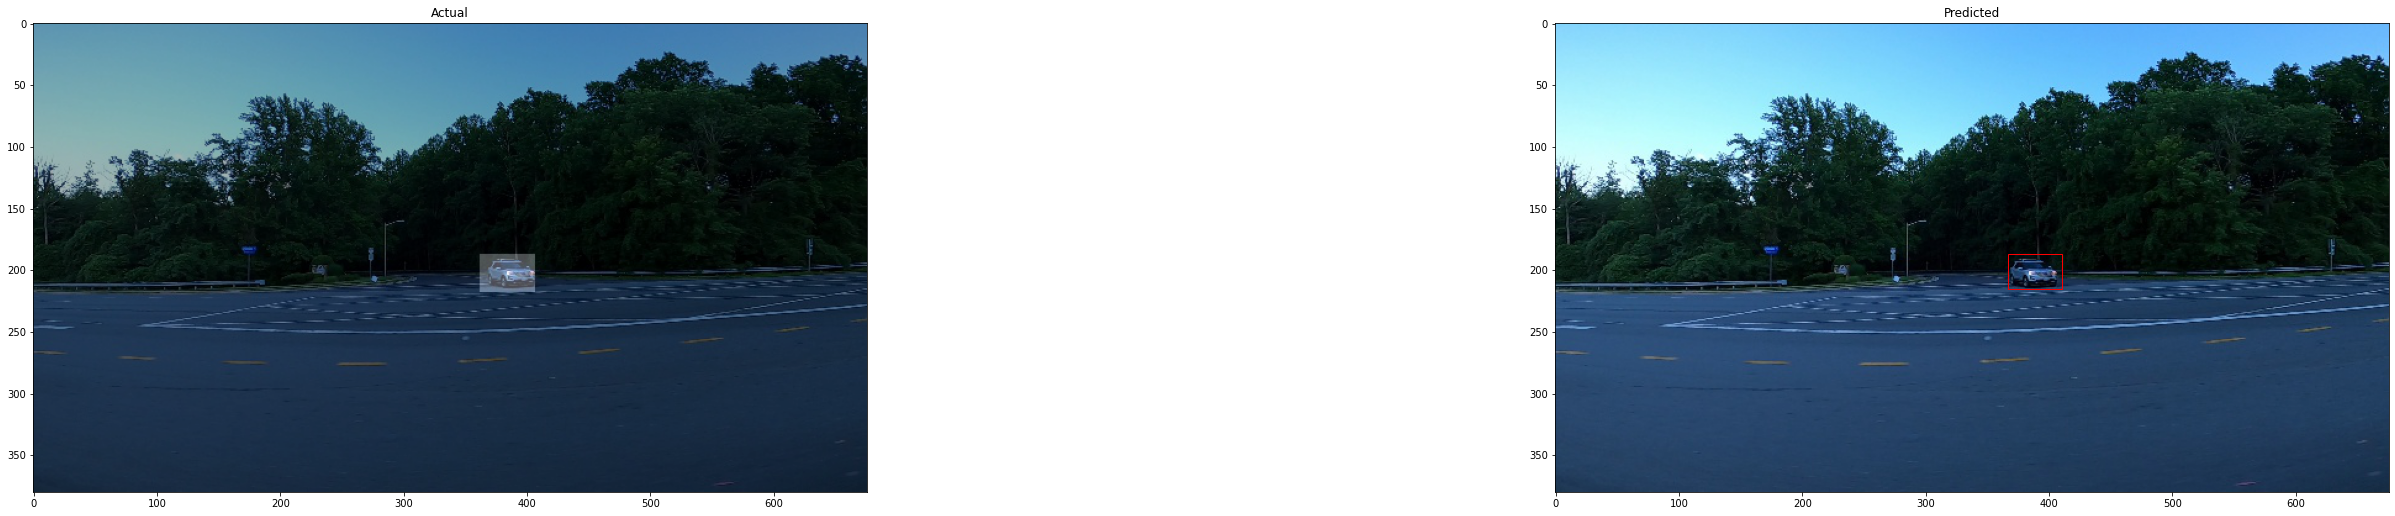

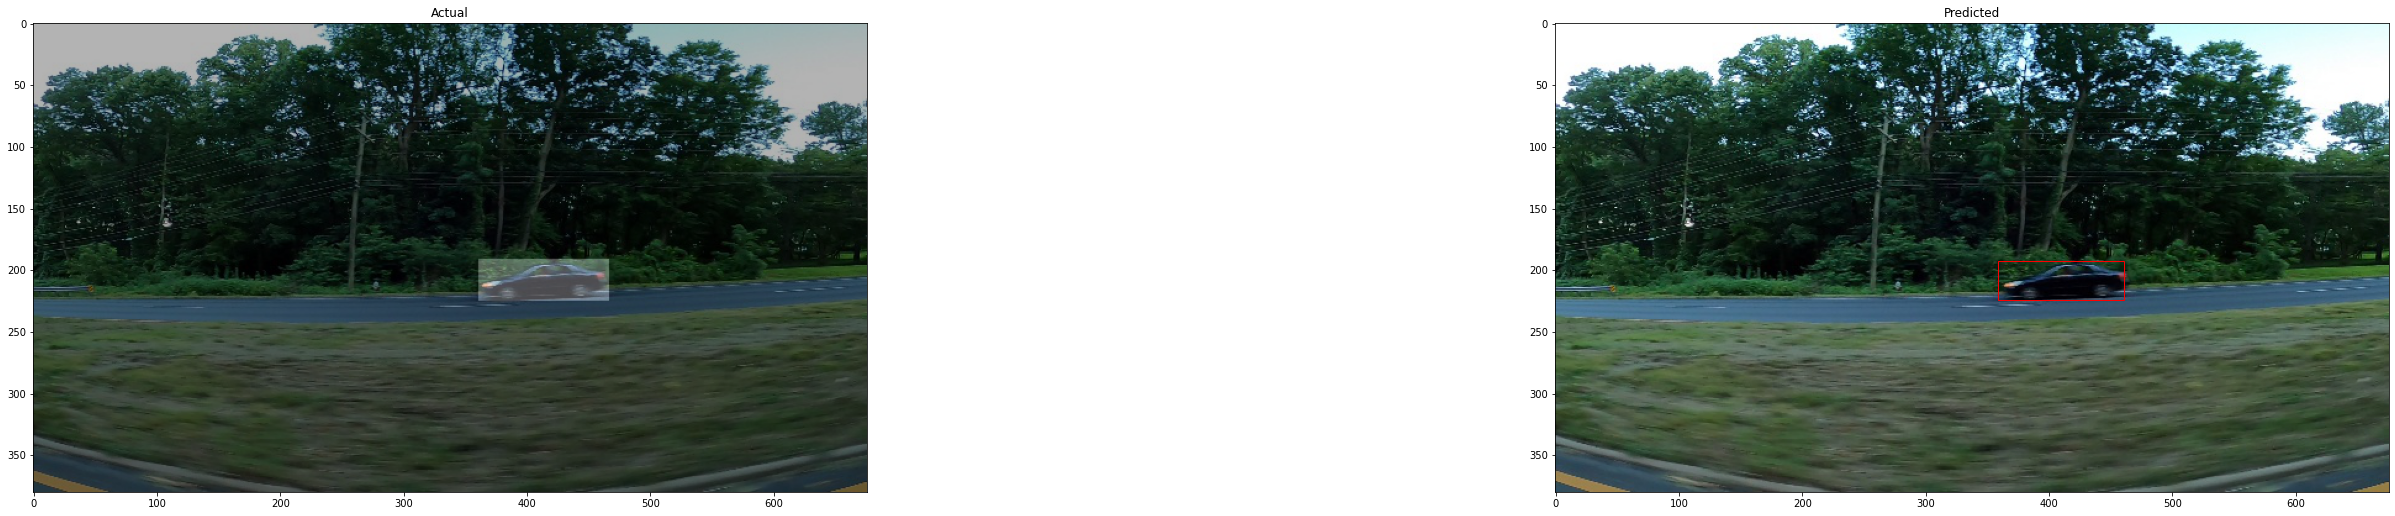

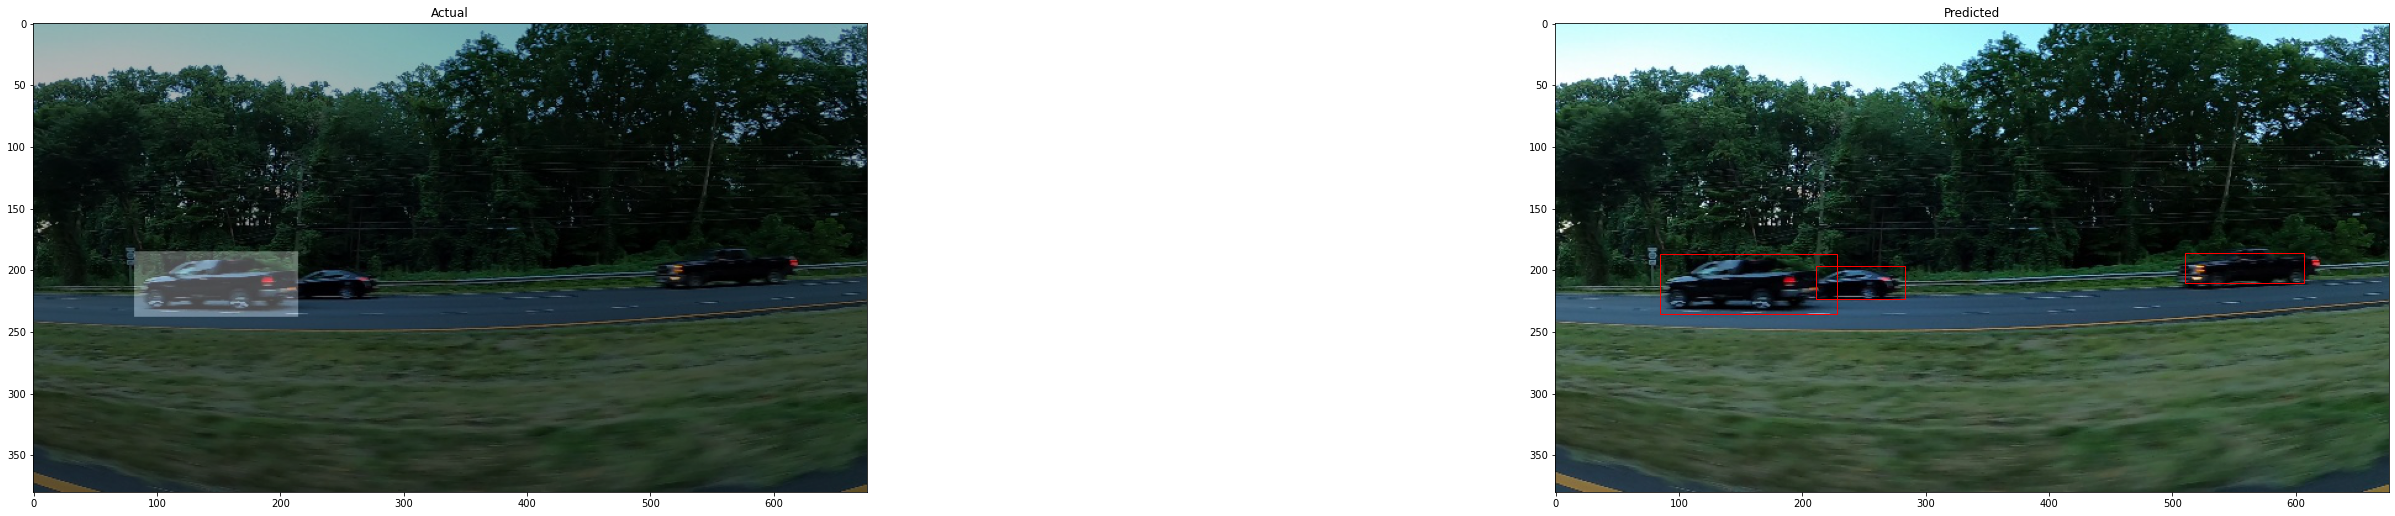

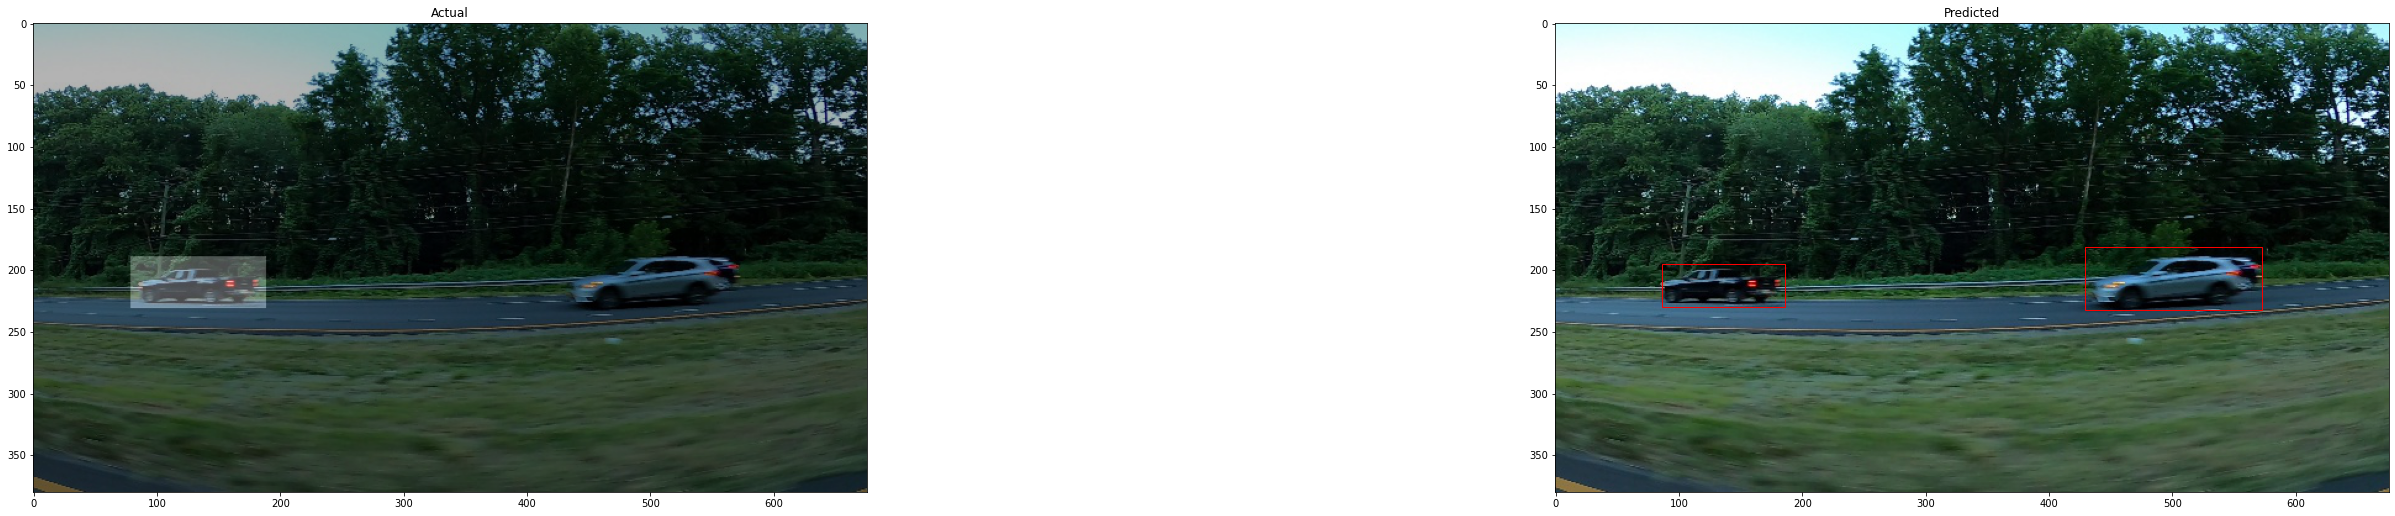

In [48]:
from matplotlib.patches import Rectangle
plot_actual_vs_predicted(val_set, model, cfg)